In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import minimize

In [7]:

def UZWA(f, g, X0, tau, Nmax, epsilon, type_contrainte='egalite'):
    """
    Résout min f(X) sous g(X) = 0 (ou <= 0) via la méthode d'Uzawa.
    
    Args:
        f: Fonction objectif (h(X))
        g: Fonction contrainte (c(X))
        X0: Point initial
        tau: Pas de mise à jour du multiplicateur (learning rate dual)
        Nmax: Nombre max d'itérations externes
        epsilon: Précision d'arrêt (sur la norme de la contrainte)
        type_contrainte: 'egalite' (g(x)=0) ou 'inegalite' (g(x)<=0)
    
    Returns:
        X: Solution optimale
        lambda_k: Multiplicateur final
        historique: Tableau des [X, lambda] pour analyse
    """
    dim = len(X0)
    X = np.array(X0, dtype=float)
    lam = 0.0 # Initialisation du multiplicateur scalaire (lambda)
    
    history = []
    
    for k in range(Nmax):
        # --- Étape 1 : Minimisation du Lagrangien par rapport à X ---
        # L(X, lam) = f(X) + lam * g(X)
        def lagrangien(x_var):
            return f(x_var) + lam * g(x_var)
        
        # On utilise un solveur rapide (BFGS) pour le sous-problème
        # Pour être purement pédagogique, on pourrait faire une descente de gradient ici aussi
        res = minimize(lagrangien, X, method='BFGS', tol=1e-5)
        X_new = res.x
        
        # Valeur de la contrainte
        gx = g(X_new)
        
        # --- Étape 2 : Mise à jour du multiplicateur (Ascension Duale) ---
        if type_contrainte == 'egalite':
            # Lambda peut être négatif ou positif
            lam_new = lam + tau * gx
        else:
            # Projection sur R+ (Lambda >= 0 pour inégalités)
            lam_new = max(0, lam + tau * gx)
            
        # Stockage
        history.append(np.hstack([X_new, [lam_new]]))
        
        # Critère d'arrêt : Si la contrainte est satisfaite à epsilon près
        # ET que lambda ne bouge plus trop
        if abs(gx) < epsilon and abs(lam_new - lam) < epsilon:
            X = X_new
            lam = lam_new
            break
            
        X = X_new
        lam = lam_new
        
    return X, lam, np.array(history)

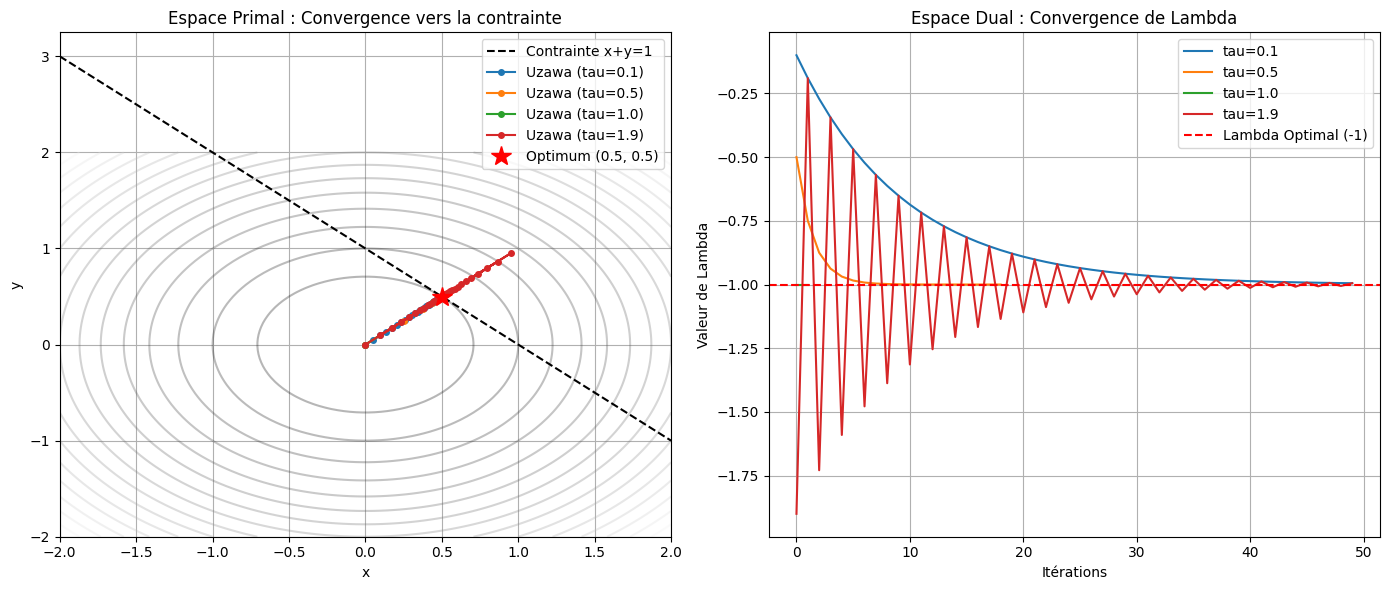

In [8]:
# Définition du problème
def f_test(X): return X[0]**2 + X[1]**2
def g_test(X): return X[0] + X[1] - 1

# Paramètres
X0 = [-1.5, -1.5]
tau_vals = [0.1, 0.5, 1.0, 1.9] # Différents pas pour analyser la convergence

plt.figure(figsize=(14, 6))

# --- Graphique 1 : Trajectoires dans l'espace primal (x, y) ---
plt.subplot(1, 2, 1)

# Fond (Isolignes de f)
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)
X_g, Y_g = np.meshgrid(x_grid, y_grid)
plt.contour(X_g, Y_g, X_g**2 + Y_g**2, levels=15, cmap='gray', alpha=0.3)
plt.plot(x_grid, 1-x_grid, 'k--', label='Contrainte x+y=1')

for tau in tau_vals:
    sol, lam_f, hist = UZWA(f_test, g_test, X0, tau=tau, Nmax=50, epsilon=1e-6)
    plt.plot(hist[:, 0], hist[:, 1], 'o-', markersize=4, label=f'Uzawa (tau={tau})')

plt.plot(0.5, 0.5, 'r*', markersize=15, label='Optimum (0.5, 0.5)')
plt.title("Espace Primal : Convergence vers la contrainte")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()

# --- Graphique 2 : Convergence du Multiplicateur Lambda ---
plt.subplot(1, 2, 2)
for tau in tau_vals:
    sol, lam_f, hist = UZWA(f_test, g_test, X0, tau=tau, Nmax=50, epsilon=1e-6)
    plt.plot(hist[:, 2], label=f'tau={tau}')

plt.axhline(-1, color='red', linestyle='--', label='Lambda Optimal (-1)')
plt.title("Espace Dual : Convergence de Lambda")
plt.xlabel("Itérations")
plt.ylabel("Valeur de Lambda")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Calcul en cours........ Terminé !

--- RÉSULTATS COMPARATIFS ---
 Tau  Itérations  Temps (s)  Err Finale X  Lambda Final
 0.1         100     0.1173  2.383274e-05          -1.0
 0.5          19     0.0208  3.564902e-09          -1.0
 1.0           2     0.0022  3.878486e-08          -1.0
 1.5         100     0.1064  7.582981e-06          -1.0
 1.9         100     0.1569  2.048397e-05          -1.0


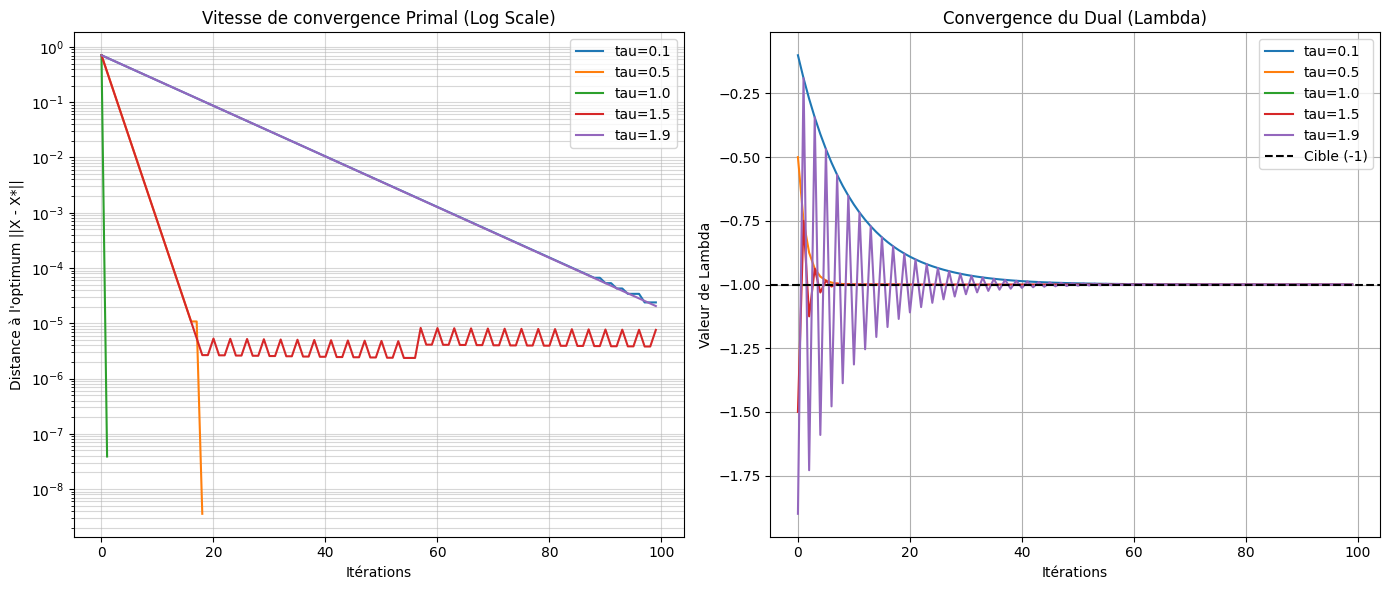

In [9]:
# --- 1. Définition du Problème ---
# Objectif : min x^2 + y^2 sous x + y = 1
# Optimum théorique : x=0.5, y=0.5, lambda=-1

THEORIQUE_X = np.array([0.5, 0.5])
THEORIQUE_LAM = -1.0

def f(X): 
    return X[0]**2 + X[1]**2

def g(X): 
    return X[0] + X[1] - 1  # = 0

# --- 2. Algorithme d'Uzawa Instrumenté ---
def uzawa_benchmark(tau, X0, Nmax, epsilon):
    X = np.array(X0, dtype=float)
    lam = 0.0 # Initialisation lambda
    
    history_err_X = []
    history_err_G = []
    history_lam = []
    
    start_time = time.time()
    iters = Nmax
    
    for k in range(Nmax):
        # A. Minimisation du Lagrangien par rapport à X
        # L(X) = f(X) + lam * g(X)
        fun_L = lambda x_var: f(x_var) + lam * g(x_var)
        
        # Résolution du sous-problème (BFGS est rapide et précis)
        res = minimize(fun_L, X, method='BFGS', tol=1e-5)
        X_new = res.x
        
        # B. Mise à jour du multiplicateur (Gradient Ascent sur le Dual)
        val_g = g(X_new)
        lam_new = lam + tau * val_g
        
        # C. Enregistrement des métriques
        dist_opt = np.linalg.norm(X_new - THEORIQUE_X)
        history_err_X.append(dist_opt)
        history_err_G.append(abs(val_g))
        history_lam.append(lam_new)
        
        # D. Critère d'arrêt
        if abs(val_g) < epsilon and abs(lam_new - lam) < epsilon:
            iters = k + 1
            break
            
        X = X_new
        lam = lam_new
        
    duration = time.time() - start_time
    
    return {
        "Tau": tau,
        "Itérations": iters,
        "Temps (s)": round(duration, 4),
        "Err Finale X": history_err_X[-1],
        "Err Contrainte": history_err_G[-1],
        "Lambda Final": round(lam, 4),
        "Hist_Err_X": history_err_X,
        "Hist_Lam": history_lam
    }

# --- 3. Exécution du Benchmark ---
taus_to_test = [0.1, 0.5, 1.0, 1.5, 1.9] # On teste du lent au rapide
X0 = [-2.0, -2.0]
Nmax = 100
epsilon = 1e-6

results = []
print("Calcul en cours...", end="")
for tau in taus_to_test:
    res = uzawa_benchmark(tau, X0, Nmax, epsilon)
    results.append(res)
    print(".", end="")
print(" Terminé !")

# --- 4. Affichage Tableau ---
df = pd.DataFrame(results)
cols_show = ["Tau", "Itérations", "Temps (s)", "Err Finale X", "Lambda Final"]
print("\n--- RÉSULTATS COMPARATIFS ---")
print(df[cols_show].to_string(index=False))

# --- 5. Visualisation Graphique ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphe 1 : Convergence vers la solution (Distance X - X*)
for res in results:
    ax1.plot(res["Hist_Err_X"], label=f'tau={res["Tau"]}')

ax1.set_yscale('log') # Échelle log pour mieux voir la convergence
ax1.set_title("Vitesse de convergence Primal (Log Scale)")
ax1.set_xlabel("Itérations")
ax1.set_ylabel("Distance à l'optimum ||X - X*||")
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.5)

# Graphe 2 : Stabilité du Multiplicateur Lambda
for res in results:
    ax2.plot(res["Hist_Lam"], label=f'tau={res["Tau"]}')

ax2.axhline(THEORIQUE_LAM, color='black', linestyle='--', label='Cible (-1)')
ax2.set_title("Convergence du Dual (Lambda)")
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de Lambda")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()